# Ames, Iowa Dataset - Linear Regression

### In this project, I construct a linear regression model to predict the sale price of houses in the city of Ames, IA.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load data
ames = pd.read_csv("ames_train.csv")

In [3]:
# Check shape
print(f'There are {ames.shape[0]} rows in the '
      f'dataset and {ames.shape[1]} columns.')

There are 2000 rows in the dataset and 82 columns.


In [4]:
# Check for duplicates
unique_PIDs = len(ames['PID'].unique())
total_PIDs = ames.shape[0]
number_of_dupes = total_PIDs - unique_PIDs
print(f'There are {number_of_dupes} duplicates in the dataset.')

There are 0 duplicates in the dataset.


In [5]:
# Train test split, seeded for replication
np.random.seed(1)

train, test = train_test_split(ames, test_size=0.2)

In [6]:
# Treat quantitative and categorical features separately
quant_cols = set(train.select_dtypes(include=['int64','float64']).columns)
cat_cols = set(train.select_dtypes(include=['object']).columns)

# 'MS_SubClass' is a categorical variable encoded as an 
# integer. 'Order' and 'PID' are merely identifiers and
# so need not be considered.
quant_cols = set([col for col in quant_cols if col not in ('MS_SubClass', 'Order', 'PID')])
cat_cols.add('MS_SubClass')

#### Rerun the following cell after data processing to ensure missing values have been accounted for:

In [7]:
# Check for missing values
train.isna().sum().sort_values(ascending=False).head(20)

Pool_QC           1593
Misc_Feature      1532
Alley             1494
Fence             1300
Fireplace_Qu       770
Lot_Frontage       278
Garage_Cond         83
Garage_Qual         83
Garage_Yr_Blt       83
Garage_Finish       83
Garage_Type         82
Bsmt_Exposure       42
Bsmt_Qual           41
Bsmt_Cond           41
BsmtFin_Type_1      41
BsmtFin_Type_2      41
Mas_Vnr_Area        16
Mas_Vnr_Type        16
Bsmt_Full_Bath       2
Bsmt_Half_Bath       2
dtype: int64

### First, we make the following plots to guide our feature engineering:
#### - Histograms of each quantitative variable
#### - Scatter plots of each quantitative variable against the target, 'SalePrice'
#### - Count plots of each categorical variable
#### - Box plots of 'SalePrice' for each categorical variable, factored by category

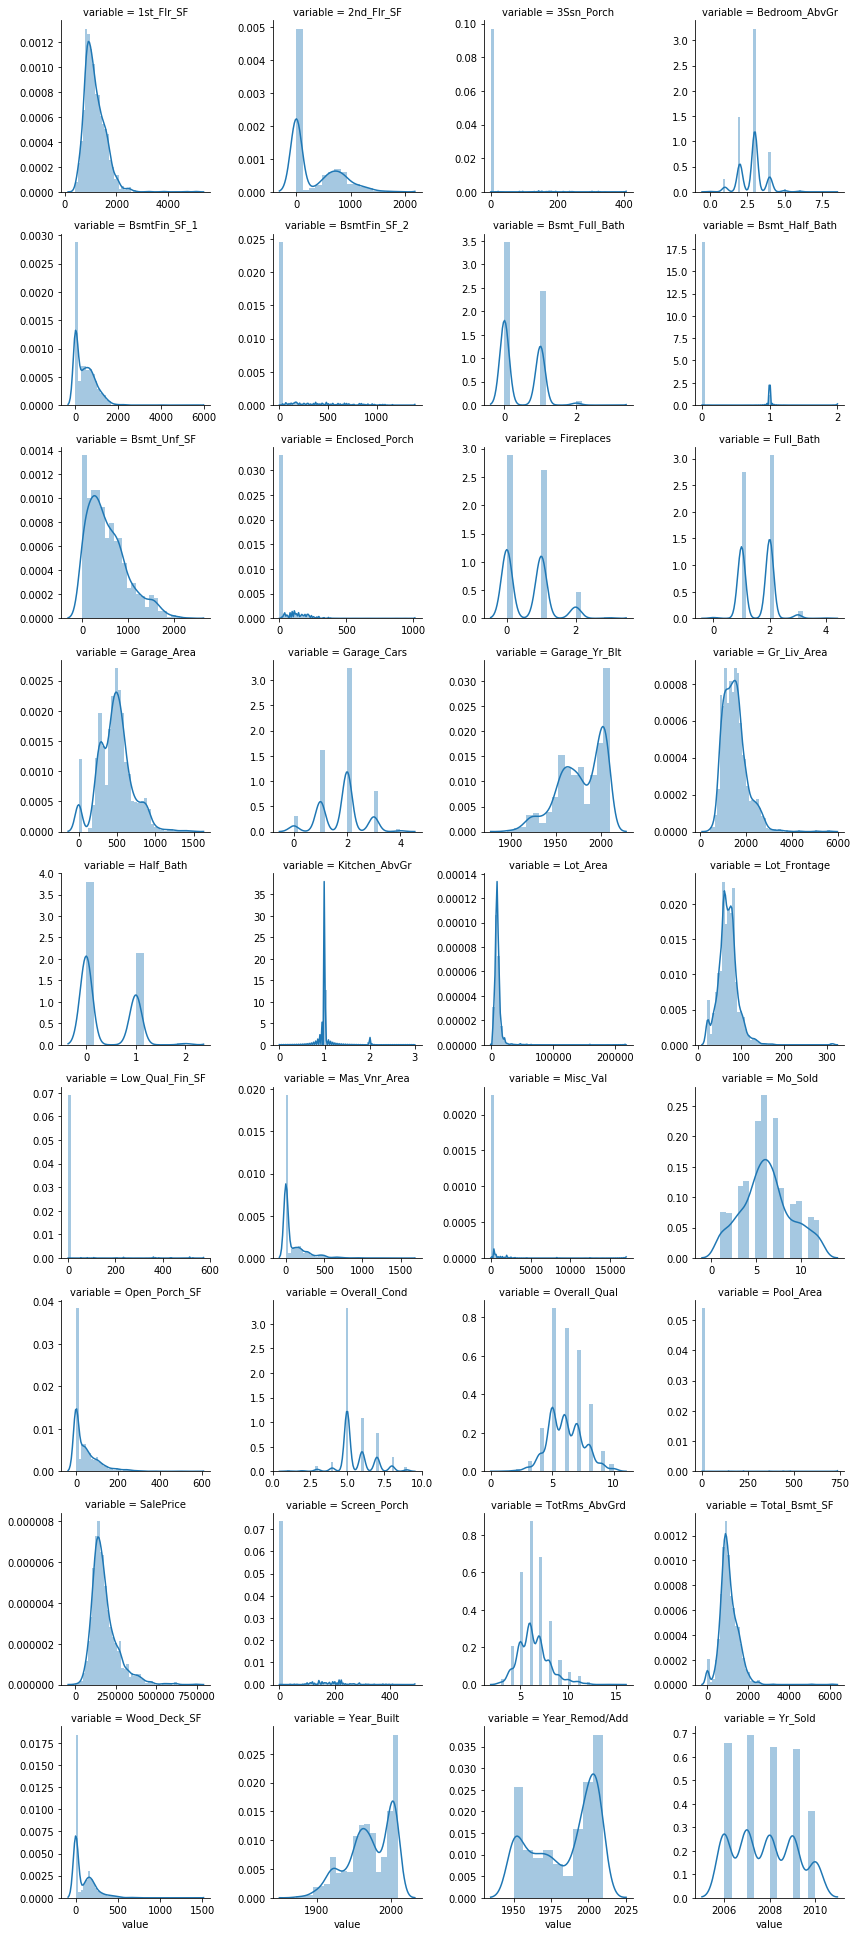

In [8]:
# Distplots of each quantitative variable
f = pd.melt(train, value_vars=sorted(quant_cols))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

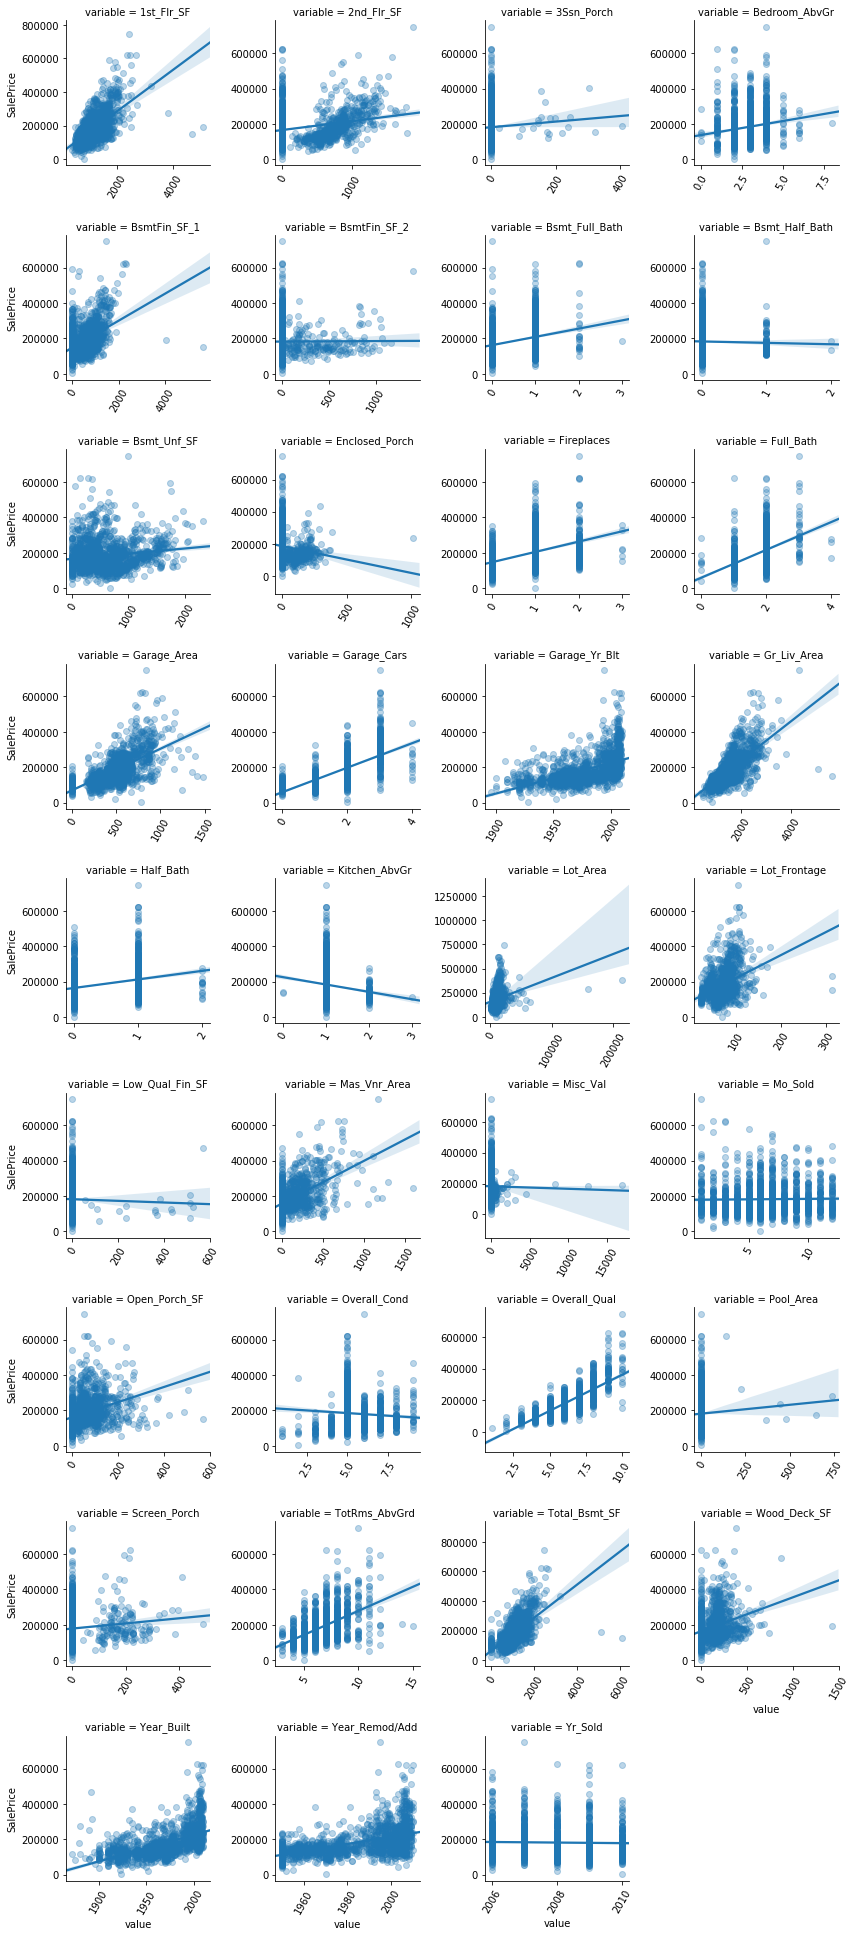

In [9]:
# Scatter plots of each quantitative variable against 'SalePrice'
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(quant_cols - {'SalePrice'}))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

/Users/efscerbo/anaconda3/envs/data100/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


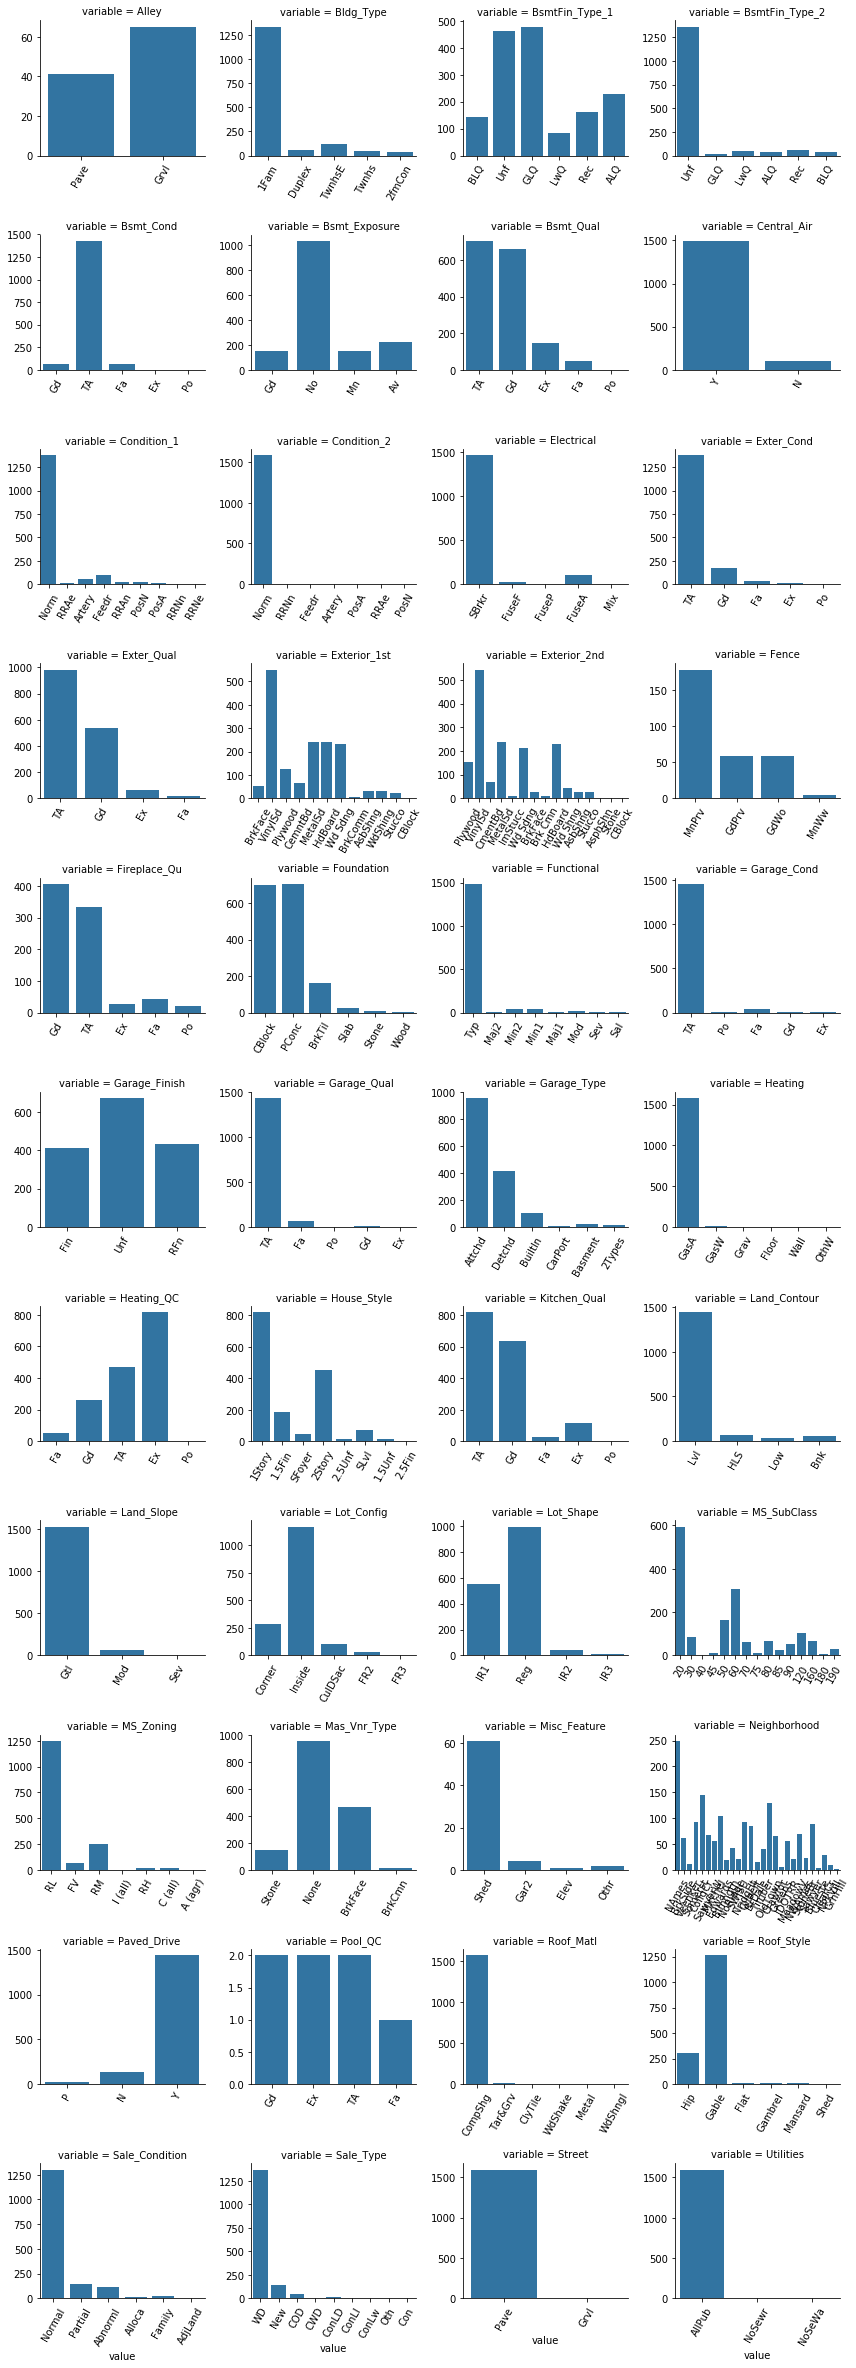

In [10]:
# Count plots of each categorical variable
f = pd.melt(train, value_vars=sorted(cat_cols))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

/Users/efscerbo/anaconda3/envs/data100/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


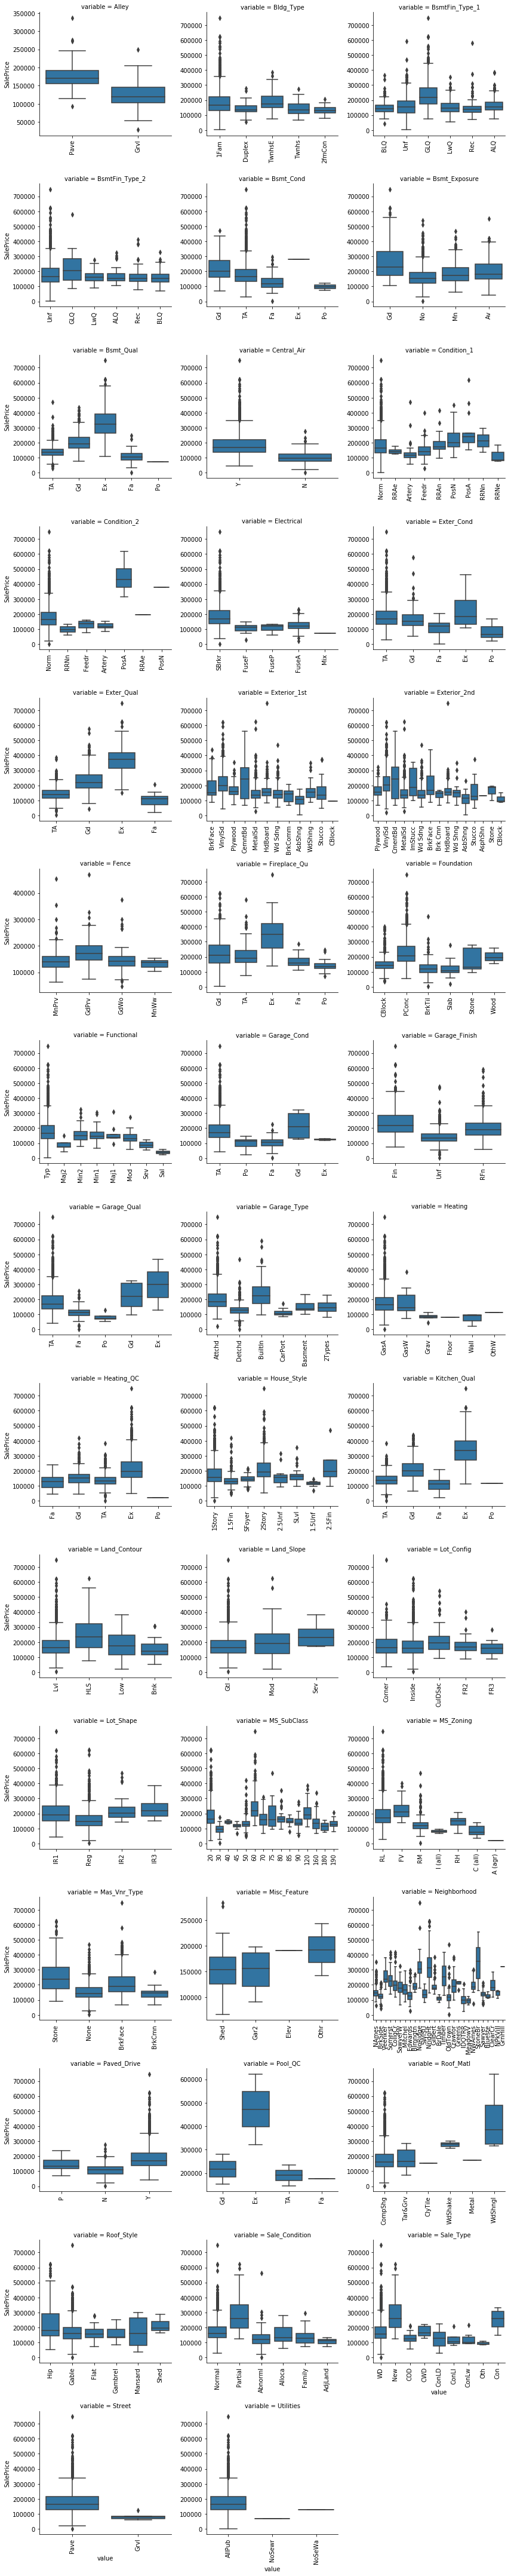

In [11]:
# Box plots of 'SalePrice' for each categorical variable,
# factored by category.
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(cat_cols))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, size=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

In [12]:
# Which features are most correlated with 'SalePrice'?
corr = train.corr()
corr.sort_values("SalePrice", ascending=False)['SalePrice']

SalePrice          1.000000
Overall_Qual       0.790427
Gr_Liv_Area        0.700001
Garage_Cars        0.649739
Garage_Area        0.628488
Total_Bsmt_SF      0.615096
1st_Flr_SF         0.613335
Year_Built         0.557441
Full_Bath          0.537940
Garage_Yr_Blt      0.532576
Mas_Vnr_Area       0.526850
Year_Remod/Add     0.523721
TotRms_AbvGrd      0.521768
Fireplaces         0.458808
BsmtFin_SF_1       0.440574
Lot_Frontage       0.358567
Open_Porch_SF      0.345150
Wood_Deck_SF       0.306285
Bsmt_Full_Bath     0.299151
Half_Bath          0.298377
2nd_Flr_SF         0.263997
Lot_Area           0.249553
Bedroom_AbvGr      0.157715
Bsmt_Unf_SF        0.155616
Screen_Porch       0.105275
3Ssn_Porch         0.044095
Pool_Area          0.038813
Mo_Sold            0.017313
BsmtFin_SF_2       0.005616
Misc_Val          -0.012251
Low_Qual_Fin_SF   -0.022447
Bsmt_Half_Bath    -0.024083
Yr_Sold           -0.026237
Order             -0.032906
MS_SubClass       -0.079529
Overall_Cond      -0

#### Here I make several notes from the above graphs that I will incorporate into my feature engineering below:

Quantitative features:

'1st_Flr_SF' - Strong linear corr w SalePrice; right-skewed, maybe apply log. 
'2nd_Flr_SF' - Decent linear corr, but many (921) 0's, which throws it off. Maybe combine w 
                '1st_Flr_SF' for a 'Total_Flr_SF' feature (no, this is the same as 'Gr_Liv_Area'
                for almost all (1575) of the houses) or use to make a 'Has_2nd_Flr' feature.
'3Ssn_Porch' - Almost all 0's. Combine w other 'Porch' features to make a 'Tot_Porch_SF'
                feature and a 'Has_Porch' feature.
'Bedroom_AbvGr' - Weirdly not as correlated w SalePrice as you'd expect. Keep for now,
                maybe drop if it doesn't do much.
'BsmtFin_SF_1' - Decent corr, but many 0's. Perhaps combine w 'BsmtFin_SF_2' and 'Bsmt_Unf_SF' 
                to make a 'Total_Bsmt_SF' feature (nope, this already exists and is equal to the
                sum of these three features for most (1316) houses). Could use this to make 
                'Has_Fin_Bsmt' feature.
'BsmtFin_SF_2' - Mostly 0's (1394). See 'BsmtFin_SF_1'
'Bsmt_Full_Bath' - Combine w other 'Bath' features to make a 'Tot_Bath' feature
'Bsmt_Half_Bath' - Combine w other 'Bath' features to make a 'Tot_Bath' feature
'Bsmt_Unf_SF' - Weakly correlated w SalePrice. Use only to make 'Has_Bsmt' feature, as above
                in 'BsmtFin_SF_1' (no need, can just use 'Total_Bsmt_SF')
'Enclosed_Porch' - Almost all 0's. Combine w other 'Porch' features to make a 'Tot_Porch_SF'
                feature and a 'Has_Porch' feature.
'Fireplaces' - Keep, but also make a 'Has_Fireplace' feature
'Full_Bath' - Combine w other 'Bath' features to make a 'Tot_Bath' feature
'Garage_Area' - Good corr; right-skewed, apply log. Also use to make 'Has_Garage' feature
'Garage_Cars' - Good corr w SalePrice, but probably highly correlated w 'Garage_Area', may
                need to drop one of the two
'Garage_Yr_Blt' - Ok corr, but equal to 'Year_Built' for most (1212) of the houses,
                prob should drop
'Gr_Liv_Area' - Strong linear corr w SalePrice; right-skewed, apply log. 
'Half_Bath' - Combine w other 'Bath' features to make a 'Tot_Bath' feature
'Kitchen_AbvGr' - Weird relationship w SalePrice, something seems off, should drop
'Lot_Area' - Decent linear corr w SalePrice; right-skewed, apply log.
'Lot_Frontage' - Decent corr, right-skewed, apply log. Also, many missing values: Impute w
                median, as in kaggle writeup
'Low_Qual_Fin_SF' - Almost all 0's (1302), should drop
'Mas_Vnr_Area' - Decent corr w SalePrice, has a couple missing values (fill in w 0), 
                and many 0's (802). May want to log transform. Also,
                can make a 'Has_Mas_Vnr' feature
'Misc_Val' - Mostly 0's, should be dropped
'Mo_Sold' - No relation w SalePrice, should be dropped
'Open_Porch_SF' - Many 0's. Combine w other 'Porch' features to make a 'Tot_Porch_SF'
                feature and a 'Has_Porch' feature.
'Overall_Cond' - Poor correlation w SalePrice, drop
'Overall_Qual' - Def keep
'Pool_Area' - Almost all 0's, but could make a 'Has_Pool' feature (nah, only
                6 houses have pools, and you don't get a good separation)
'SalePrice' - Right-skewed, take log
'Screen_Porch' - Many 0's. Combine w other 'Porch' features to make a 'Tot_Porch_SF'
                feature and a 'Has_Porch' feature.
'TotRms_AbvGrd' - Def keep
'Total_Bsmt_SF' - Strong corr w SalePrice, slightly right-skewed, try log. Also, use 
                to make 'Has_Bsmt' feature
'Wood_Deck_SF' - Many 0's, use to make a 'Has_Deck' feature
'Year_Built' - Decent corr, but prob better to use to make a 'New_House' feature
'Year_Remod/Add' - Use to make a 'Was_Remodeled' feature
'Yr_Sold' - No corr w SalePrice, drop

Categorical features:

'Alley' - Maybe use to pick out houses with gravel alleys, even though 
                there's only a few (65) of them
'Bldg_Type' - Maybe use to pick out houses that are either 1Fam or TwnhsE, 
                but there's 1455 of those and only 139 of the others
'BsmtFin_Type_1' - Convert to 'GLQ', 'No Basement', 'Other'
'BsmtFin_Type_2' - Almost all are 'Unf', doesn't look useful, drop
'Bsmt_Cond' - Almost all are 'TA', drop
'Bsmt_Exposure' - Just look for 'Gd' exposure
'Bsmt_Qual' - Convert to 'Ex', 'Gd', 'Other'
'Central_Air' - Def keep
'Condition_1' - The majority (1372) are 'Norm', hard to see how this would be
                useful, drop
'Condition_2' - The vast majority (1577) are 'Norm', drop
'Electrical' - Just look for 'SBrkr'
'Exter_Cond' - The majority (1372) are 'TA'. Try binning together 'Ex',
                'Gd', and 'TA', and also bin 'Fa' and 'Po', two categories total
'Exter_Qual' - Def keep, bin 'TA' and 'Fa' together
'Exterior_1st' - Not terribly useful, could just bin together 'VinylSd' and 
                'CemntBd' and look for those
'Exterior_2nd' - Doesn't look markedly different from 'Exterior_1st', drop
'Fence' - Doesn't look very useful, drop
'Fireplace_Qu' - Def keep, bin together 'TA' and 'Gd', and bin together
                'No Fireplace', 'Fa', and 'Po', leaving 3 categories total
'Foundation' - Use to check for 'PConc'
'Functional' - Doesn't look super useful, maybe just look for 'Typ'
'Garage_Cond' - Doesn't look useful, drop
'Garage_Finish' - Keep, prob keep every category, looks good
'Garage_Qual' - Doesn't look useful, drop
'Garage_Type' - Bin 'Attchd' and 'BuiltIn' and check for that
'Heating' - Vast majority (1572) of houses are 'GasA', doesn't look useful, drop
'Heating_QC' - Just check for 'Ex'
'House_Style' - Doesn't look super useful. Could bin '1Story' and '2Story'
                and check for that, but that's a maybe
'Kitchen_Qual' - Convert to 'Ex', 'Gd', and 'Other'
'Land_Contour' - Doesn't look useful, drop
'Land_Slope' - Doesn't look useful, drop
'Lot_Config' - Doesn't look useful, drop
'Lot_Shape' - Maybe just look for 'Reg'? Could also just drop
'MS_SubClass' - Multiple ways to bin this to try and make it useful, prob need
                to experiment. Initally, could try binning together 20, 60, and 120 as
                'good subclasses' and then 30, 45, 50, 180 as 'poor subclasses'
                (turns out, got best separation using 20, 60, 80, and 120 for 'good
                subclasses', and didn't use any 'poor subclasses')
'MS_Zoning' - Doesn't look super useful, maybe just check for 'FV', make a 
                'Floating_Village' feature (nah, that's not so good, just drop)
'Mas_Vnr_Type' - Convert to 'Stone', 'BrkFace', and 'Other'
'Misc_Feature' - Vast majority (1528) have 'None', drop
'Neighborhood' - Use to make 'In_Rich_Neighborhood' and 'In_Poor_Neighborhood' features
'Paved_Drive' - Almost all (1433) are 'Y', doesn't look useful, drop
'Pool_QC' - Vast majority (1588) have 'No Pool', drop
'Roof_Matl' - Vast majority (1572) are 'CompShg', drop
'Roof_Style' - Convert to 'Hip' and 'Other' (nope, that doesn't look so
                useful, just drop)
'Sale_Condition' - Use to check for 'Partial'
'Sale_Type' - Use to check for 'New'
'Street' - Almost all (1588 to 6) are 'Pave', but there does seem to be a
                reasonable difference between them. Keep for now, might help
                w a handful of houses in the test set
'Utilities' - Useless, drop

### Next, I write several functions that will be piped together to form my data processing pipeline. This ensures that the training set and the test set are treated identically. (We obviously only remove outliers from the training set.)

In [13]:
# Remove outliers, in accordance with preliminary EDA as well
# as suggestions in the documentation. Keep rows with NaN's in
# 'Lot_Frontage', as we'll be imputing those values below.
# Want to remove outliers before imputing, though.
def remove_outliers(train):
    train = (
        train[(train['Gr_Liv_Area'] <= 4000) 
              & (train['SalePrice'] >= 3000) 
              & (train['Lot_Area'] <= 150000) 
              & ((train['Lot_Frontage'] <= 300) 
                 | (train['Lot_Frontage'].isna()))]
    )
    
    return train

In [14]:
# The comments below refer to the training set, but we shall
# run this function on both the training and test sets, so
# as to guarantee we treat them the same

def handle_missing_data(data): 
    # The 'Lot_Frontage' feature has several (277) missing values.
    # We would like to use this feature, so we impute the missing 
    # values as the median value for all houses in the same neighborhood,
    # unless all homes in that neighborhood are missing values,
    # in which case we fill with the median for the whole feature.
    data.loc[:, 'Lot_Frontage'] = (
        data
        .groupby('Neighborhood')['Lot_Frontage']
        .apply(lambda x: x.fillna(x.median()))
        .fillna(data['Lot_Frontage'].median())
    )
    
    # There are some houses missing values for both 'Mas_Vnr_Type'
    # and 'Mas_Vnr_Area'. For these, fill in the values with 'None',
    # 0, respectively.
    data['Mas_Vnr_Type'].fillna('None', inplace=True)
    data['Mas_Vnr_Area'].fillna(0, inplace=True)
    
    # There are three houses with 'Mas_Vnr_Type' == 'None' but with
    # 'Mas_Vnr_Area' > 0. Two of these houses have 'Mas_Vnr_Area' == 1;
    # for those, we set 'Mas_Vnr_Area' to 0. The other house has 
    # 'Mas_Vnr_Area' == 312; for that house, we change its 
    # 'Mas_Vnr_Type' to the most common non-'None' value, 'BrkFace'
    data.loc[(data['Mas_Vnr_Type'] == 'None') & (data['Mas_Vnr_Area'] == 1), 'Mas_Vnr_Area'] = 0
    data.loc[(data['Mas_Vnr_Type'] == 'None') & (data['Mas_Vnr_Area'] > 1), 'Mas_Vnr_Type'] = 'BrkFace'
    
    # There is one house with 'Mas_Vnr_Type' != 'None', yet its
    # 'Mas_Vnr_Area' is 0. Its 'Mas_Vnr_Type' is 'Stone'; we set
    # its 'Mas_Vnr_Area' to the mean of all houses w stone masonry.
    data.loc[(data['Mas_Vnr_Type'] == 'Stone') & (data['Mas_Vnr_Area'] == 0), 'Mas_Vnr_Area'] = \
        data.loc[data['Mas_Vnr_Type'] == 'Stone', 'Mas_Vnr_Area'].mean()
    
    # There is a house missing values for most features involving
    # the garage, but which has a value for 'Garage_Type'. Set that
    # value to NaN.
    data.loc[(data['Garage_Qual'].isna()) & (~data['Garage_Type'].isna()), 'Garage_Type'] = np.nan
    
    # There is a house with reasonable values for most features
    # involving the basement, but which is missing a value for
    # 'Bsmt_Exposure'. Not knowing anything about this house, 
    # we'll set it to the most commonly occurring value.
    data.loc[(~data['Bsmt_Qual'].isna()) & (data['Bsmt_Exposure'].isna()), 'Bsmt_Exposure'] = 'No'
    
    # There are a few houses missing values for various quantitative
    # basement-related features. We fill with 0's, assuming these
    # houses have no basements.
    data['BsmtFin_SF_1'].fillna(value=0, inplace=True)
    data['BsmtFin_SF_2'].fillna(value=0, inplace=True)
    data['Bsmt_Full_Bath'].fillna(value=0, inplace=True)
    data['Bsmt_Half_Bath'].fillna(value=0, inplace=True)
    data['Bsmt_Unf_SF'].fillna(value=0, inplace=True)
    data['Total_Bsmt_SF'].fillna(value=0, inplace=True)
    
    # Several variables with missing values aren't actually
    # missing: The documentation states they were marked 'NA',
    # meaning that feature does not apply to the house in
    # question. This 'NA', however, is read into pandas as
    # a NaN. We here fill the missing values in those columns
    # with the corresponding description in the documentation.
    data['Alley'].fillna(value='No alley', inplace=True)
    data['BsmtFin_Type_1'].fillna(value='No Basement', inplace=True)
    data['BsmtFin_Type_2'].fillna(value='No Basement', inplace=True)
    data['Bsmt_Cond'].fillna(value='No Basement', inplace=True)
    data['Bsmt_Exposure'].fillna(value='No Basement', inplace=True)
    data['Bsmt_Qual'].fillna(value='No Basement', inplace=True)
    data['Fence'].fillna(value='No Fence', inplace=True)
    data['Fireplace_Qu'].fillna(value='No Fireplace', inplace=True)
    data['Garage_Cond'].fillna(value='No Garage', inplace=True)
    data['Garage_Finish'].fillna(value='No Garage', inplace=True)
    data['Garage_Qual'].fillna(value='No Garage', inplace=True)
    data['Garage_Type'].fillna(value='No Garage', inplace=True)
    data['Misc_Feature'].fillna(value='None', inplace=True)
    data['Pool_QC'].fillna(value='No Pool', inplace=True)
    
    # There is one house missing a value for 'Electrical'. We
    # fill it with the most common value, 'SBrkr'.
    data['Electrical'].fillna(value='SBrkr', inplace=True)

    # There is one house in the ames_test.csv data (i.e., the
    # "actual" test set) missing values for 'Garage_Cars' and
    # for 'Garage_Area'. We fill with 0's, assuming the house
    # has no garage.
    data['Garage_Cars'].fillna(value=0, inplace=True)
    data['Garage_Area'].fillna(value=0, inplace=True)
    
    return data

In [15]:
# Below, we define functions to identify "good" subclasses
# in the 'MS_SubClass' feature, as well as rich and poor
# neighborhoods. We define these using our training set so
# that the resulting lists don't change when we process our
# test set.

def good_subclasses():
    good_subclasses = (
        train
        .groupby('MS_SubClass')['SalePrice']
        .median()
        .sort_values(ascending=False)
        .index[:4]
    )
    return good_subclasses

def rich_neighborhoods():
    rich_neighborhoods = (
        train
        .groupby('Neighborhood')
        .filter(lambda g: len(g) >= 20) # Restrict to neighborhoods w reasonable number of houses
        .groupby('Neighborhood')['SalePrice']
        .agg(np.median)
        .sort_values(ascending=False)
        .index[:4]
    )
    return rich_neighborhoods

def poor_neighborhoods():
    poor_neighborhoods = (
        train
        .groupby('Neighborhood')
        .filter(lambda g: len(g) >= 20) # Restrict to neighborhoods w reasonable number of houses
        .groupby('Neighborhood')['SalePrice']
        .agg(np.median)
        .sort_values(ascending=False)
        .index[-5:]
    )
    return poor_neighborhoods

In [16]:
def make_new_features(data):
    # Make new quantitative features
    data['Total_Bath'] = (
        data['Full_Bath'] + data['Bsmt_Full_Bath'] 
        + 0.5 * (data['Half_Bath'] + data['Bsmt_Half_Bath'])
    )
    data['Total_Porch_SF'] = (
        data['3Ssn_Porch'] + data['Enclosed_Porch'] 
        + data['Open_Porch_SF'] + data['Screen_Porch']
    )
    data['Total_SF'] = data['Gr_Liv_Area'] + data['Total_Bsmt_SF']
    
    # For each of the features most correlated w 'SalePrice',
    # create a new column with that feature squared. Also,
    # make a cubed column for the top feature, 'Overall_Qual'
    cols_to_square = (
        ['1st_Flr_SF', 'Garage_Cars', 'Total_Bath', 'Overall_Qual', 
         'Gr_Liv_Area', 'Total_Bsmt_SF', 'Total_SF']
    )
    for col in cols_to_square:
        data[col+'^2'] = data[col] ** 2
    data['Overall_Qual^3'] = data['Overall_Qual'] ** 3
    
    # Make new boolean features
    data['1_or_2Story'] = data['House_Style'].isin(['1Story', '2Story'])
    data['Ex_Heating'] = data['Heating_QC'] == 'Ex'
    data['Good_Bldg_Type'] = data['Bldg_Type'].isin(['1Fam', 'TwnhsE'])
    data['Good_Bsmt_Exposure'] = data['Bsmt_Exposure'] == 'Gd'
    data['Good_Exter_Cond'] = data['Exter_Cond'].isin(['Ex', 'Gd', 'TA'])
    data['Good_Exterior'] = data['Exterior_1st'].isin(['CemntBd', 'VinylSd'])
    data['Good_Garage_Type'] = data['Garage_Type'].isin(['Attchd', 'BuiltIn'])
    data['Good_SubClass'] = data['MS_SubClass'].isin(good_subclasses())
    data['Gravel_Alley'] = data['Alley'] == 'Grvl'
    data['Has_2nd_Flr'] = data['2nd_Flr_SF'] > 0
    data['Has_Bsmt'] = data['Total_Bsmt_SF'] > 0
    data['Has_Deck'] = data['Wood_Deck_SF'] > 0
    data['Has_Fin_Bsmt'] = (data['BsmtFin_SF_1'] + data['BsmtFin_SF_2']) > 0
    data['Has_Fireplace'] = data['Fireplaces'] > 0
    data['Has_Garage'] = data['Garage_Area'] > 0
    data['Has_Mas_Vnr'] = data['Mas_Vnr_Area'] > 0
    data['Has_Porch'] = data['Total_Porch_SF'] > 0
    data['Is_New'] = data['Year_Built'] > 1995
    data['New_Sale'] = data['Sale_Type'] == 'New'
    data['Partial_Sale'] = data['Sale_Condition'] == 'Partial'
    data['PConc_Found'] = data['Foundation'] == 'PConc'
    data['Poor_Neighborhood'] = data['Neighborhood'].isin(poor_neighborhoods())
    data['Reg_Lot_Shape'] = data['Lot_Shape'] == 'Reg'
    data['Rich_Neighborhood'] = data['Neighborhood'].isin(rich_neighborhoods())
    data['SBrkr_Elec'] = data['Electrical'] == 'SBrkr'
    data['Typ_Func'] = data['Functional'] == 'Typ'
    # The Ames dataset documentation says that 'Year_Remod/Add'
    # is "same as construction date if no remodeling or additions".
    data['Was_Remodeled'] = data['Year_Built'] != data['Year_Remod/Add']
    
    # Modify existing features by combining subsets of
    # categories to get a better separation in 'SalePrice'
    data['BsmtFin_Type_1'].replace(['ALQ', 'BLQ', 'LwQ', 'Rec', 'Unf'], 'Other', inplace=True)
    data['Bsmt_Qual'].replace(['Fa', 'No Basement', 'Po', 'TA'], 'Other', inplace=True)
    data['Exter_Qual'].replace(['Fa', 'TA'], 'Average', inplace=True)
    (
        data['Fireplace_Qu'].replace({'Gd': 'Good', 'TA': 'Good', 'Fa': 'Not Good', 
                                      'No Fireplace': 'Not Good', 'Po': 'Not Good'}, 
                                     inplace=True)
    )
    data['Kitchen_Qual'].replace(['Fa', 'Po', 'TA'], 'Other', inplace=True)
    data['Mas_Vnr_Type'].replace(['BrkCmn', 'None'], 'Other', inplace=True)
    
    return data

In [17]:
# Log-transform various features
def log_transform(data, features):
    for feature in features:
        data.loc[:, feature] = data[feature].apply(np.log1p)
    
    return data

features_to_transform = (
    {'1st_Flr_SF', 'Gr_Liv_Area', 'Lot_Area', 
     'Lot_Frontage', 'SalePrice'}
)

In [18]:
# Drop unneeded features
def drop_cols(data, cols):
    data = data.drop(cols, axis=1)
    return data

# Quantitative columns to drop
drop_quant_cols = (
    {'2nd_Flr_SF', '3Ssn_Porch', 'BsmtFin_SF_1', 'BsmtFin_SF_2',
     'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Bsmt_Unf_SF', 'Enclosed_Porch', 
     'Full_Bath', 'Garage_Yr_Blt', 'Half_Bath', 'Kitchen_AbvGr',
     'Low_Qual_Fin_SF', 'Misc_Val', 'Mo_Sold', 'Open_Porch_SF',
     'Overall_Cond', 'Pool_Area', 'Screen_Porch', 'Wood_Deck_SF',
     'Year_Built', 'Year_Remod/Add', 'Yr_Sold'}
)

# Categorical columns to drop
drop_cat_cols = (
    {'Alley', 'Bldg_Type', 'BsmtFin_Type_2', 'Bsmt_Cond', 
     'Bsmt_Exposure', 'Condition_1', 'Condition_2', 'Electrical',
     'Exter_Cond', 'Exterior_1st', 'Exterior_2nd', 'Fence', 
     'Foundation', 'Functional', 'Garage_Cond', 'Garage_Qual', 
     'Garage_Type', 'Heating', 'Heating_QC', 'House_Style',
     'Land_Contour', 'Land_Slope', 'Lot_Config', 'Lot_Shape',
     'MS_SubClass', 'MS_Zoning', 'Misc_Feature', 'Neighborhood', 
     'Paved_Drive', 'Pool_QC', 'Roof_Matl', 'Roof_Style', 
     'Sale_Condition', 'Sale_Type', 'Utilities'}
)

In [19]:
# Below we shall perform standardization and one-hot encoding.
# To do this we need a copy of our training set that has
# undergone the processing up to this point
proc_train = (
    train.copy()
    .pipe(remove_outliers)
    .pipe(handle_missing_data)
    .pipe(make_new_features)
    .pipe(drop_cols, drop_quant_cols | drop_cat_cols | {'Order', 'PID'})
)

In [20]:
# Perform standardization on quantitative features
quant_features = quant_cols - (drop_quant_cols | {'SalePrice'})

# Fit StandardScaler object to proc_train
standardizer = StandardScaler()
standardizer.fit(proc_train.loc[:, quant_features])

def standardize_quant_cols(data):
    data.loc[:, quant_features] = standardizer.transform(data.loc[:, quant_features])
    return data

In [21]:
# One-hot encode categorical data. Use DictVectorizer in case
# train and test have different categories in certain features.

# Fit DictVectorizer object to proc_train
vec_enc = DictVectorizer()
vec_enc.fit(proc_train.to_dict(orient='records'))

# One-hot encoding function for use in pipeline
def one_hot_encode(data):
    data = vec_enc.transform(data.to_dict(orient='records')).toarray()
    data = pd.DataFrame(data, columns = vec_enc.get_feature_names())
    return data

#### Here, all the functions defined above are piped together to form my data processing pipeline:

In [22]:
# I tried many permutations of processing, some involving
# standardization, some not, some involving log-transforms,
# some not, including many different sets of features to
# so transform. The below yielded the lowest training RSME.
def data_process_pipeline(data):
    data = (
        data
        .pipe(handle_missing_data)
        .pipe(make_new_features)
        #.pipe(log_transform, features_to_transform - {'SalePrice'})
        .pipe(drop_cols, drop_quant_cols | drop_cat_cols | {'Order', 'PID'})
        .pipe(standardize_quant_cols)
        .pipe(one_hot_encode)
    )
    
    return data

In [23]:
# Final dataframes before modeling; only remove outliers from train
processed_train = data_process_pipeline(remove_outliers(train.copy()))
processed_test = data_process_pipeline(test.copy())

X_train = processed_train.drop('SalePrice', axis=1)
y_train = processed_train['SalePrice']
X_test = processed_test.drop('SalePrice', axis=1)
y_test = processed_test['SalePrice']

#### Re-plot some of the above graphs to see the effects of processing:

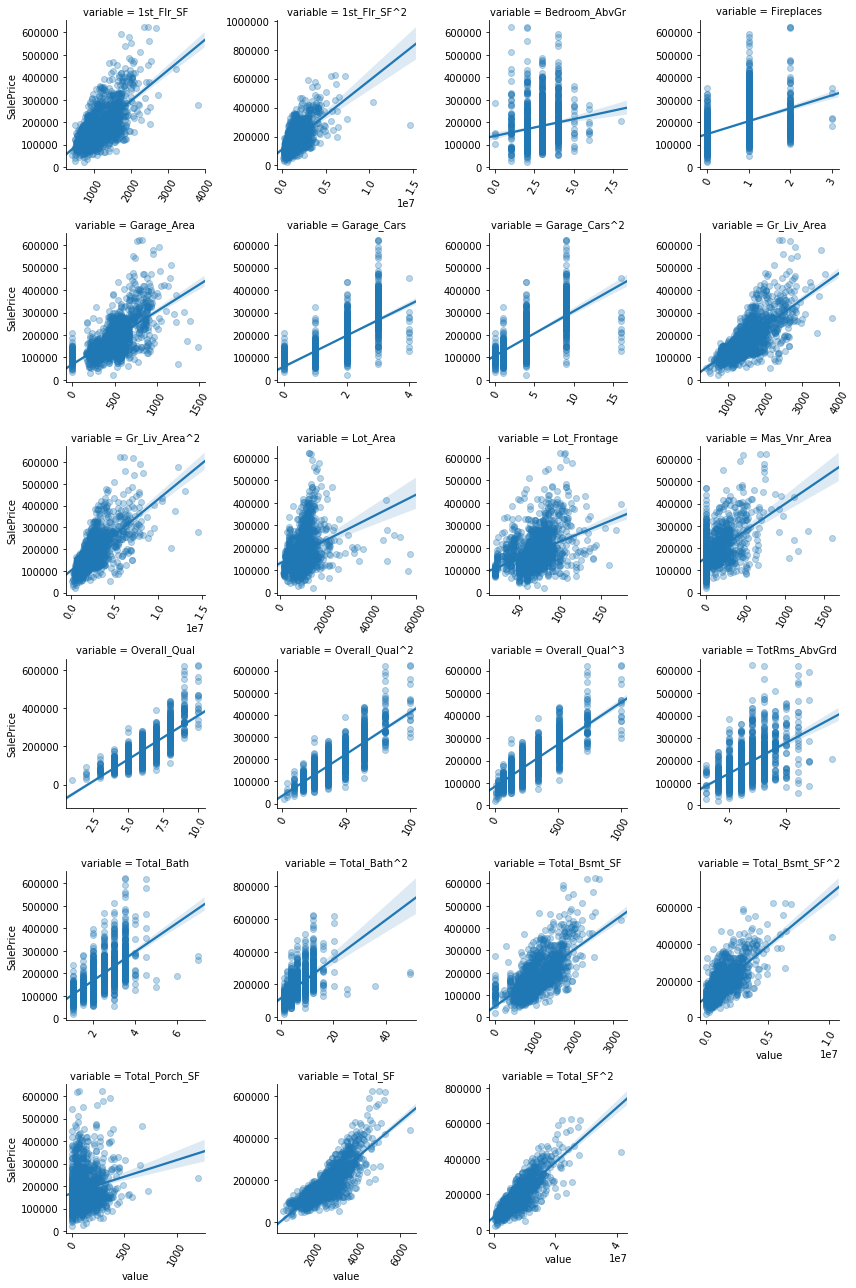

In [24]:
# Scatter plots of each quantitative variable against 'SalePrice'
quant_cols = set(proc_train.select_dtypes(include=['int64','float64']).columns)
f = pd.melt(proc_train, id_vars=['SalePrice'], value_vars=sorted(quant_cols - {'SalePrice'}))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

/Users/efscerbo/anaconda3/envs/data100/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


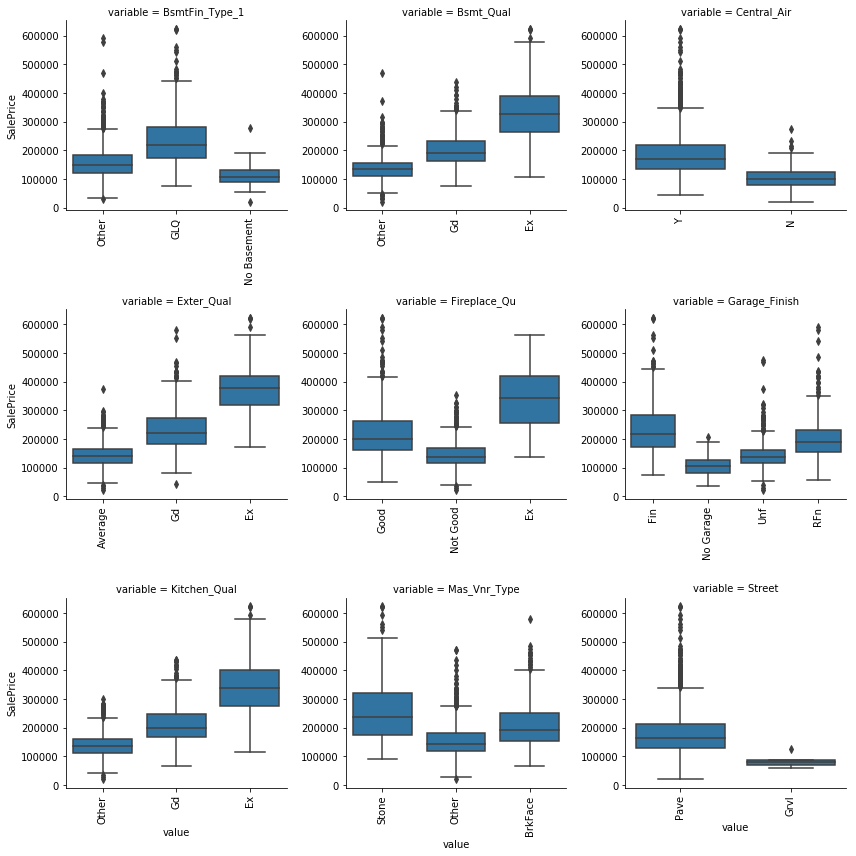

In [25]:
# Boxplots of 'SalePrice' for each categorical variable,
# factored by category.
cat_cols = set(proc_train.select_dtypes(include=['object']).columns)
f = pd.melt(proc_train, id_vars=['SalePrice'], value_vars=sorted(cat_cols))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, size=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

In [26]:
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [27]:
# Tried several models, including LassoCV, RidgeCV,
# and ElasticNetCV. LassoCV yielded best results
alphas = np.arange(0.1, 200.1, .1)
model = lm.LassoCV(alphas=alphas, cv=5)

# Fit and predict
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(model.alpha_), 2)} is '
      f'{round(rmse(y_test, y_predicted), 2)}.')

/Users/efscerbo/anaconda3/envs/data100/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The validation RMSE for this model with alpha=23.0 is 22505.51.


/Users/efscerbo/anaconda3/envs/data100/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


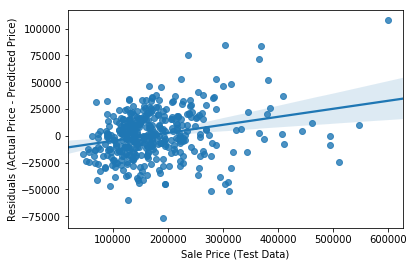

In [28]:
# Plot residuals against actual values
residuals = y_test - y_predicted
ax = sns.regplot(y_test, residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)');

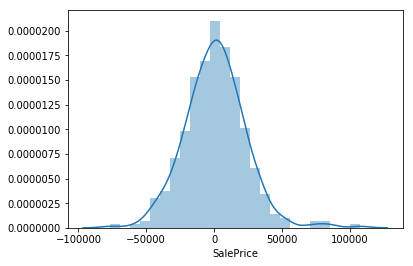

In [29]:
# Plot histogram of residuals
sns.distplot(residuals);

In [30]:
# Print R^2 score
print('R^2: ', r2_score(y_test, y_predicted))

R^2:  0.922052935121


In [31]:
# Print model coefficients
for i in sorted(zip(model.coef_, X_train.columns)):
    print(i)

(-16795.885778004696, 'Has_Mas_Vnr')
(-9206.1752453370282, 'Garage_Cars')
(-9170.0874939469741, 'Central_Air=N')
(-8353.0415739998152, 'Mas_Vnr_Type=Other')
(-7834.3815749520736, 'Kitchen_Qual=Other')
(-6355.6759017239447, 'Fireplace_Qu=Ex')
(-6056.4501424485734, 'Poor_Neighborhood')
(-5289.3821204440173, 'Total_Bsmt_SF')
(-4638.2797724244638, 'Bedroom_AbvGr')
(-4224.9889623679883, 'Has_Fireplace')
(-2377.7844490539537, 'Gravel_Alley')
(-2271.9346841154802, 'Overall_Qual^2')
(-2195.2561280161922, 'Reg_Lot_Shape')
(-1658.0207395190839, 'Has_Porch')
(-1626.1900730284349, 'Exter_Qual=Average')
(-1510.6684231461109, 'BsmtFin_Type_1=Other')
(-1470.2871730921054, 'Street=Grvl')
(-1342.6617021300312, 'Bsmt_Qual=Other')
(-844.05770372580116, 'Garage_Finish=RFn')
(-224.69896908089308, 'Total_Bath^2')
(-17.042671351215731, 'Total_SF')
(-0.0051927997826481543, '1st_Flr_SF^2')
(0.0, 'BsmtFin_Type_1=No Basement')
(0.0, 'Bsmt_Qual=Gd')
(0.0, 'Central_Air=Y')
(0.0, 'Exter_Qual=Gd')
(-0.0, 'Fireplace_

### Thus, we see that my linear-regression-with-regularization model does a respectable job of predicting 'SalePrice' from various other features. The validation RMSE is approximately \\$22,500, which is about 12% of the mean sale price: \\$180,776. There are no obvious trends in the plot of residuals against actual price, although I'm clearly underfitting on some of the more expensive houses. Also, the histogram of the residuals looks approximately normal. Finally, my R$^2$ score is quite high, 92.2%.

#### Note: The entire above analysis was actually done only on the training portion of the Ames dataset. That is, my train-test split at the very beginning is really a train-validation split. The actual test set has the response variable withheld. The following block of code produces a csv of the model predictions on the actual test set for submission to Kaggle.

In [ ]:
# Make csv for submitting to kaggle
from datetime import datetime

test_data = pd.read_csv("ames_test.csv")
processed = data_process_pipeline(test_data.copy()).drop('SalePrice', axis=1)

submission_df = pd.DataFrame(
    {
    "PID": test_data['PID'],
    "SalePrice": model.predict(processed)
    }
)

timestamp = datetime.isoformat(datetime.now()).split(".")[0]

submission_df.to_csv(f'submission_{timestamp}', index=False)